# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [24]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_anual_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-28 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,521.0,2022-07-28,521.0
1,1,521.0,2022-07-29,521.0
2,1,521.0,2022-08-02,521.0
3,2,1042.0,2022-08-07,1042.0
4,1,521.0,2022-08-10,521.0


Filtro para obtener muestra de datos

In [25]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [26]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.18,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


14:50:34 - cmdstanpy - INFO - Chain [1] start processing
14:50:35 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [27]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1573 2026-11-26
1574 2026-11-27
1575 2026-11-28
1576 2026-11-29
1577 2026-11-30


Paso 5: Realizar la Predicción (Forecast)

In [28]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds           yhat     yhat_lower     yhat_upper
1573 2026-11-26  265922.241046  217299.418669  315984.884826
1574 2026-11-27  266152.548653  219968.743169  314180.719558
1575 2026-11-28  287040.825060  238049.321085  337592.286246
1576 2026-11-29  315956.676797  260306.650044  369983.429151
1577 2026-11-30  271802.252947  218788.316165  318956.235297


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

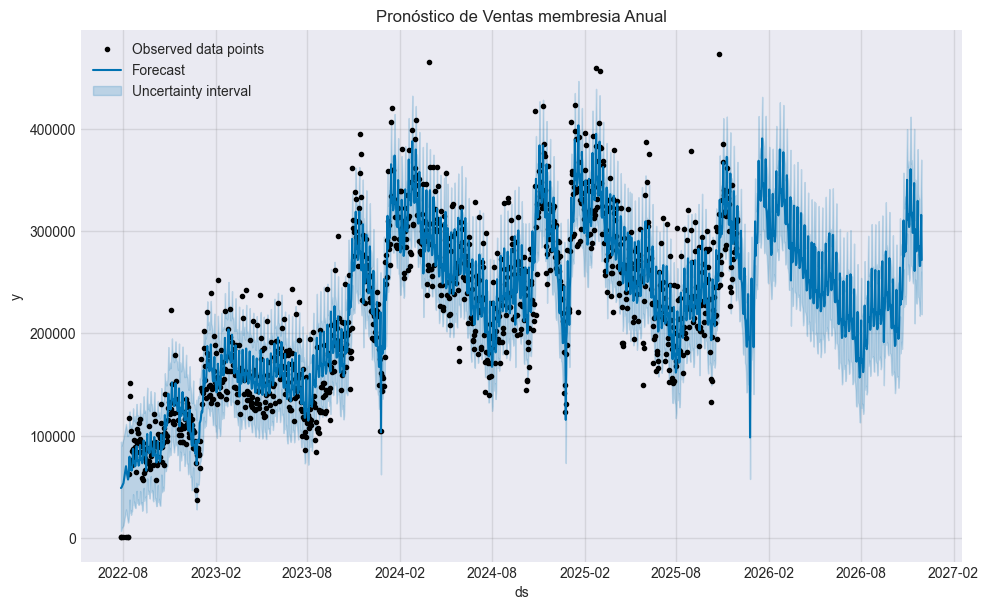

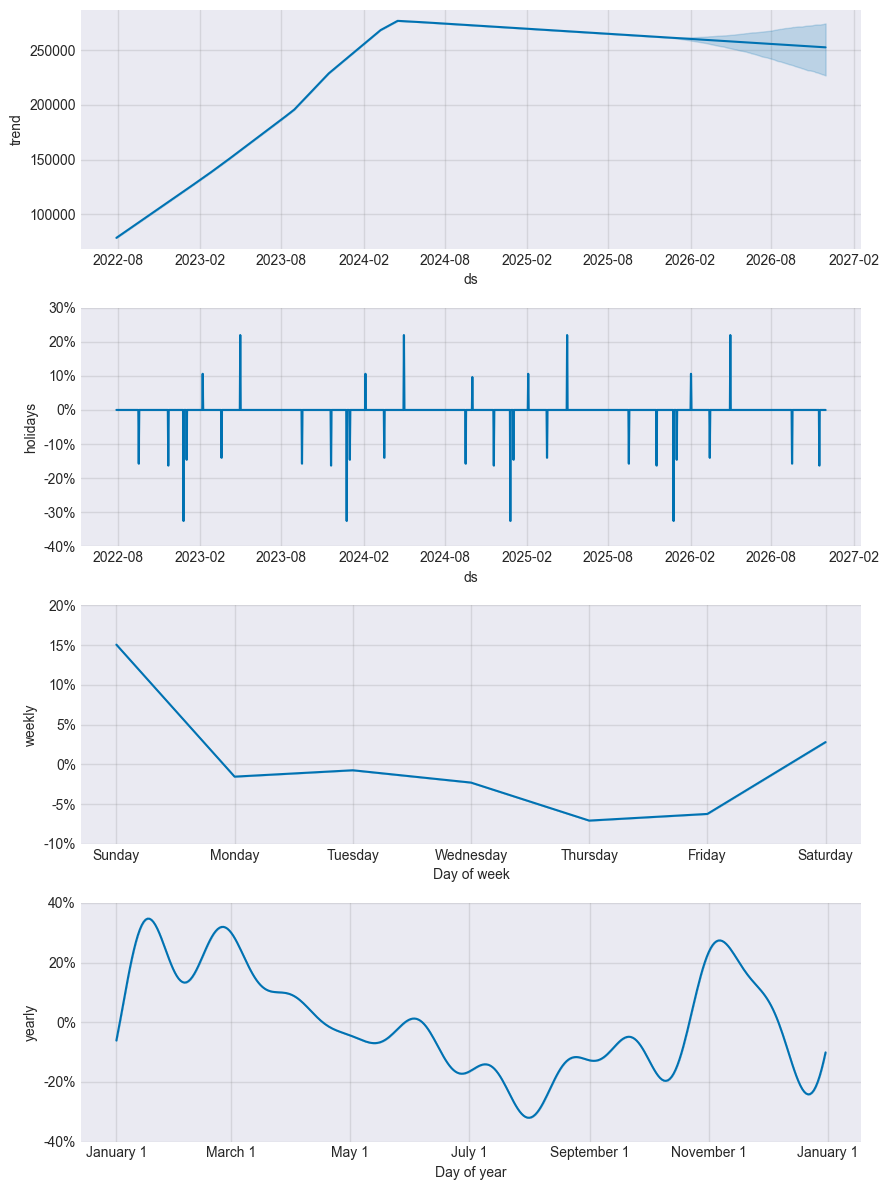

In [29]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas membresia Anual")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [30]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month         yhat  yhat_lower   yhat_upper
0   2022-07     98025.89    15440.37    184375.11
1   2022-08   1706041.30   702403.03   2727395.01
2   2022-09   2496716.46  1211598.97   3759806.51
3   2022-10   2945054.57  1628128.46   4254239.55
4   2022-11   3918858.16  2661557.34   5210366.89
5   2022-12   3176294.71  1875172.99   4481647.22
6   2023-01   4803359.63  3502797.81   6121024.13
7   2023-02   4658851.85  3465826.10   5857591.78
8   2023-03   5139155.52  3831456.69   6452303.01
9   2023-04   4712922.53  3446267.21   5979510.13
10  2023-05   4840612.01  3527713.92   6147373.72
11  2023-06   4724226.34  3459214.75   6011228.13
12  2023-07   4515535.33  3195547.02   5828355.48
13  2023-08   4752476.28  3449527.79   6067163.03
14  2023-09   5511548.56  4248141.05   6785288.16
15  2023-10   6278392.02  4968570.58   7615346.69
16  2023-11   8187621.72  6918037.24   9471762.71
17  2023-12   6511918.82  5180141.03   7818768.04
18  2024-01   9401097.48  8081234.19  10696529.49


In [31]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_anual_2026_monthly.csv")

In [32]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]14:50:36 - cmdstanpy - INFO - Chain [1] start processing
14:50:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]14:50:37 - cmdstanpy - INFO - Chain [1] start processing
14:50:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s]14:50:37 - cmdstanpy - INFO - Chain [1] start processing
14:50:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


  horizon          rmse      mape
0  9 days  31000.624005  0.091503
1 10 days  33014.223400  0.101829
2 11 days  33795.946057  0.107475
3 12 days  36064.152811  0.119469
4 13 days  39361.670446  0.134835
